In [27]:
import re
import string
from sklearn.preprocessing import StandardScaler, LabelEncoder
import nltk
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter 
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
import tensorflow as tf
import string
import re
from collections import Counter

[nltk_data] Downloading package stopwords to /Users/manoj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
#Put in the file path to the dataset created from extractingauthors.ipynb
df = pd.read_csv("./enron.csv")
df = df.drop(["Email Folder"], axis=1)
#We need only the top 20 authors ordered by number of emails found in either the
#sent folder or _sent_mail folder

#Add top_authors = df.value_counts(["Folder"])[:X] for the number of authors required
# Change X to 5,10,15 to test with 5, 10, 15 authors
top_authors = df.value_counts(["Folder"])[:5]
df = df.loc[df["Folder"].isin(list(top_authors.index.get_level_values(0)))].drop(["Unnamed: 0"], axis=1).reset_index(drop=True)
df = df[df["Text"]!=" "]
df = df[df["Text"]!="\n"]
df = df.dropna()

In [29]:
df["Folder"].value_counts()

mann-k          8167
kaminski-v      5926
dasovich-j      4805
germany-c       4571
shackleton-s    4003
Name: Folder, dtype: int64

Here we are using the enron.csv file created from the noteboook "STEP2_ExtractingAuthorEmails.ipynb". This csv contains all the sent emails from 20 authors, and the extracted body of text from each email. You can change the X value too 5,10,15 to test with the corresponding number of authors. Here we are testing with 5 authors.

In [30]:
def uniform_distribution(samples_per_author, df):
    df3 = pd.DataFrame(columns=["Author", "Folder", "File", "Text", "Raw Text"]) 
    for folder in df["Folder"].value_counts().index:
        df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)
    return df3

In [31]:
# Change the number of samples per author here
df = uniform_distribution(4000, df)
print(df["Folder"].value_counts())
df

mann-k          4000
kaminski-v      4000
dasovich-j      4000
germany-c       4000
shackleton-s    4000
Name: Folder, dtype: int64


,Author,Folder,File,Text,Raw Text,Message ID
0,Kay,mann-k,543.0,Here is the latest version. Our meeting is sc...,Message-ID: <22360372.1075845931625.JavaMail.e...,22360372.1075845931625.
1,Kay,mann-k,67.0,Per your request.\n,Message-ID: <2759744.1075845920112.JavaMail.ev...,2759744.1075845920112.
2,Kay,mann-k,2643.0,The word is that giving the notice could put t...,Message-ID: <30826773.1075846093464.JavaMail.e...,30826773.1075846093464.
3,Kay,mann-k,691.0,I'm not particularly wild about many of the ch...,Message-ID: <18356955.1075845935087.JavaMail.e...,18356955.1075845935087.
4,"Mann, Kay",mann-k,191.0,I'm happy to look at another format. This was...,Message-ID: <7652644.1075861733089.JavaMail.ev...,7652644.1075861733089.
...,...,...,...,...,...,...
19995,Sara,shackleton-s,357.0,Do you have a draft?\n\n,Message-ID: <26239005.1075844525500.JavaMail.e...,26239005.1075844525500.
19996,Sara,shackleton-s,5359.0,Jason:\n\nHere's my suggestion for item (ix) [...,Message-ID: <13586110.1075844905248.JavaMail.e...,13586110.1075844905248.
19997,Sara,shackleton-s,72.0,Looks fine to me. SS\n\n,Message-ID: <5237013.1075844518930.JavaMail.ev...,5237013.1075844518930.
19998,Sara,shackleton-s,193.0,I spoke with Dale Neuner (confirm desk) a few ...,Message-ID: <22890009.1075844521680.JavaMail.e...,22890009.1075844521680.


The function uniform_distribution is used to sample the appropriate number of emails from the number of chosen authors. As you can initially see the number of emails per author is unbalanced with the highest being around 8000 and the lowest being around 4000. To ensure equal distribution we random sampled 4000 emails from each of the 5 authors.

In [32]:
def text_process(text):
    #Remove Punctuation Marks
    text = text.lower()
    nopunct = ""
    clean_final = []
    for char in text:
        if re.match(r"\w", char) or re.match(r" ", char):
            nopunct += char
        elif re.match(r" ", char):
            nopunct += char
        else:
            nopunct += " "
    for word in nopunct.split():
        if not word in stop_words:
            clean_final.append(word)
    nopunct=" ".join(clean_final)
    return nopunct

In [33]:
#Process all the text in each row in the df dataset
proccessed_text = df["Text"].apply(lambda row: text_process(row))
proccessed_text

0        latest version meeting scheduled tomorrow 300 ...
1                                              per request
2        word giving notice could put equipment balance...
3        particularly wild many changes proposed ge see...
4          happy look another format one michelle gave kay
                               ...                        
19995                                                draft
19996    jason suggestion item ix additional event defa...
19997                                        looks fine ss
19998    spoke dale neuner confirm desk minutes ago see...
19999    tana attached l c provisions deutsche bank mas...
Name: Text, Length: 20000, dtype: object

In [34]:
df["Processed Text"] = proccessed_text

Here we are doing text preprocessing - remove all non alphanumeric characters, and removing the stop words, and adding that as a column to the dataframe

In [35]:
tokenized_text = df["Processed Text"].apply(lambda row: word_tokenize(row))
df["Tokens"] = tokenized_text

Converting the processed text to tokens which will then be used to find the vector in the Glove pretrained vector model

In [36]:
y = df["Folder"]
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

Here we are label encoding our target variable Y, which in this case is the folder name or author name of the sent email.

In [37]:
def vectorize(list_of_docs, model):

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

This function takes input of a list of tokens, a trained word2vec model. The function then goes through all the tokens and finds the appropriate word2vec vector and appends the found vector to a list called vectors. To represent the all the word vectors present in the list vectors, we take the average of the vectors and return that to represent the list of tokens passed into the function. If none of the tokens passed in were found in the glove word dictionary a zero vector is returned.

In [39]:
X = df["Tokens"].to_numpy()
kf = KFold(n_splits=10, random_state=1, shuffle=True)
i = 1
clf = RandomForestClassifier()
training_accuracy = []
testing_accuracy = []
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    tokenized_docs = X_train
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
    vectorized_docs = vectorize(tokenized_docs, model=model)
    
    test_tokenized_docs = X_test
    test_vectorized_docs = vectorize(test_tokenized_docs, model=model)
    
    clf.fit(vectorized_docs, y_train)
    training_accuracy.append(clf.score(vectorized_docs, y_train))
    testing_accuracy.append(clf.score(test_vectorized_docs, y_test))
    print("Round {}".format(i))
    print("Training Accuracy - {}".format(training_accuracy[i-1]))
    print("Testing Accuracy - {}".format(testing_accuracy[i-1]))
    i = i + 1
print("Average Training Accuracy")
print(sum(training_accuracy)/len(training_accuracy))
print("Average Testing Accuracy")
print(sum(testing_accuracy)/len(testing_accuracy))

Round 1
Training Accuracy - 0.9705555555555555
Testing Accuracy - 0.7585
Round 2
Training Accuracy - 0.9707777777777777
Testing Accuracy - 0.7265
Round 3
Training Accuracy - 0.9702222222222222
Testing Accuracy - 0.729
Round 4
Training Accuracy - 0.9706111111111111
Testing Accuracy - 0.7485
Round 5
Training Accuracy - 0.9713888888888889
Testing Accuracy - 0.748
Round 6
Training Accuracy - 0.9706666666666667
Testing Accuracy - 0.723
Round 7
Training Accuracy - 0.9705555555555555
Testing Accuracy - 0.7515
Round 8
Training Accuracy - 0.9704444444444444
Testing Accuracy - 0.7565
Round 9
Training Accuracy - 0.9706111111111111
Testing Accuracy - 0.7645
Round 10
Training Accuracy - 0.9705555555555555
Testing Accuracy - 0.745
Average Training Accuracy
0.9706388888888888
Average Testing Accuracy
0.7451


Here we are taking the Tokens column and do 10 fold cross validation with word2vec and RandomForests.
The unique training data tokens are found and used to train the word2vec model.
We then use the vectorizer function to vectorize all the tokens per email, and get one 100d vector representing the entire email. 
We then use the RandomForest to get our training and testing accuracies.
Average Training Accuracy
0.9704944444444445
Average Testing Accuracy
0.74885

In [40]:
X = df["Tokens"].to_numpy()
kf = KFold(n_splits=10, random_state=1, shuffle=True)
i = 1
clf = LogisticRegression(n_jobs=1, C=1e5, max_iter=100000)
training_accuracy = []
testing_accuracy = []
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    tokenized_docs = X_train
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
    vectorized_docs = vectorize(tokenized_docs, model=model)
    
    test_tokenized_docs = X_test
    test_vectorized_docs = vectorize(test_tokenized_docs, model=model)
    
    clf.fit(vectorized_docs, y_train)
    training_accuracy.append(clf.score(vectorized_docs, y_train))
    testing_accuracy.append(clf.score(test_vectorized_docs, y_test))
    print("Round {}".format(i))
    print("Training Accuracy - {}".format(training_accuracy[i-1]))
    print("Testing Accuracy - {}".format(testing_accuracy[i-1]))
    i = i + 1
print("Average Training Accuracy")
print(sum(training_accuracy)/len(training_accuracy))
print("Average Testing Accuracy")
print(sum(testing_accuracy)/len(testing_accuracy))

Round 1
Training Accuracy - 0.7410555555555556
Testing Accuracy - 0.7425
Round 2
Training Accuracy - 0.7416666666666667
Testing Accuracy - 0.7325
Round 3
Training Accuracy - 0.7446666666666667
Testing Accuracy - 0.7195
Round 4
Training Accuracy - 0.7477222222222222
Testing Accuracy - 0.739
Round 5
Training Accuracy - 0.7498333333333334
Testing Accuracy - 0.7345
Round 6
Training Accuracy - 0.7423333333333333
Testing Accuracy - 0.7295
Round 7
Training Accuracy - 0.7466111111111111
Testing Accuracy - 0.7425
Round 8
Training Accuracy - 0.7365555555555555
Testing Accuracy - 0.74
Round 9
Training Accuracy - 0.7495
Testing Accuracy - 0.7375
Round 10
Training Accuracy - 0.7376666666666667
Testing Accuracy - 0.735
Average Training Accuracy
0.7437611111111111
Average Testing Accuracy
0.73525


Here we are taking the Tokens column and do 10 fold cross validation with word2vec and LogisticRegression.
The unique training data tokens are found and used to train the word2vec model.
We then use the vectorizer function to vectorize all the tokens per email, and get one 100d vector representing the entire email. 
We then use the LogisticRegression to get our training and testing accuracies.
Average Training Accuracy
0.7484777777777778
Average Testing Accuracy
0.7414

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

tokenized_docs = X_train
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
vectorized_docs = vectorize(tokenized_docs, model=model)
    
test_tokenized_docs = X_test
test_vectorized_docs = vectorize(test_tokenized_docs, model=model)

parameters = {"C": [1.0, 10], "gamma": [1, 'auto', 'scale']}


model_clf = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10, n_jobs=-1).fit(vectorized_docs, y_train)
training_accuracy = model_clf.score(vectorized_docs, y_train)
testing_accuracy = model_clf.score(test_vectorized_docs, y_test)
print("Training Accuracy")
print(training_accuracy)
print("Testing Accuracy")
print(testing_accuracy)

Training Accuracy
0.8923880597014925
Testing Accuracy
0.7621212121212121


Here we are using train test split to first intially find the best parameters for Support Vector Machine. With the best parameters using train test split we are getting Training Accuracy
0.8880597014925373
Testing Accuracy
0.7692424242424243

In [42]:
model_clf.best_params_

{'C': 10, 'gamma': 1}

In [43]:
X = df["Tokens"].to_numpy()
kf = KFold(n_splits=10, random_state=1, shuffle=True)
i = 1
clf = model_clf # Referencing the previous Support Vector Classifier with the best parameters
training_accuracy = []
testing_accuracy = []
for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    tokenized_docs = X_train
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
    vectorized_docs = vectorize(tokenized_docs, model=model)
    
    test_tokenized_docs = X_test
    test_vectorized_docs = vectorize(test_tokenized_docs, model=model)
    
    clf.fit(vectorized_docs, y_train)
    training_accuracy.append(clf.score(vectorized_docs, y_train))
    testing_accuracy.append(clf.score(test_vectorized_docs, y_test))
    print("Round {}".format(i))
    print("Training Accuracy - {}".format(training_accuracy[i-1]))
    print("Testing Accuracy - {}".format(testing_accuracy[i-1]))
    i = i + 1
print("Average Training Accuracy")
print(sum(training_accuracy)/len(training_accuracy))
print("Average Testing Accuracy")
print(sum(testing_accuracy)/len(testing_accuracy))

Round 1
Training Accuracy - 0.9046111111111111
Testing Accuracy - 0.769
Round 2
Training Accuracy - 0.9072777777777777
Testing Accuracy - 0.758
Round 3
Training Accuracy - 0.9058888888888889
Testing Accuracy - 0.7425
Round 4
Training Accuracy - 0.9111666666666667
Testing Accuracy - 0.76
Round 5
Training Accuracy - 0.9097222222222222
Testing Accuracy - 0.7505
Round 6
Training Accuracy - 0.9094444444444445
Testing Accuracy - 0.742
Round 7
Training Accuracy - 0.9058333333333334
Testing Accuracy - 0.757
Round 8
Training Accuracy - 0.9055
Testing Accuracy - 0.768
Round 9
Training Accuracy - 0.9057777777777778
Testing Accuracy - 0.763
Round 10
Training Accuracy - 0.9101666666666667
Testing Accuracy - 0.747
Average Training Accuracy
0.907538888888889
Average Testing Accuracy
0.7556999999999999


Using the best parameters for SVM, we are doing 10 fold cross validation. 
Average Training Accuracy
0.907538888888889
Average Testing Accuracy
0.7556999999999999

In [46]:
wordvec_training_acc_rf = 0.9704944444444445 * 100
wordvec_testing_acc_rf = 0.74885 * 100
wordvec_training_acc_lr = 0.7484777777777778 * 100
wordvec_testing_acc_lr = 0.7414 * 100
wordvec_training_acc_svm = 0.907538888888889 * 100
wordvec_acc_svm = 0.7556999999999999 * 100
training_acc = [wordvec_training_acc_rf, wordvec_training_acc_lr, wordvec_training_acc_svm]
testing_acc = [wordvec_testing_acc_rf, wordvec_testing_acc_lr, wordvec_acc_svm]


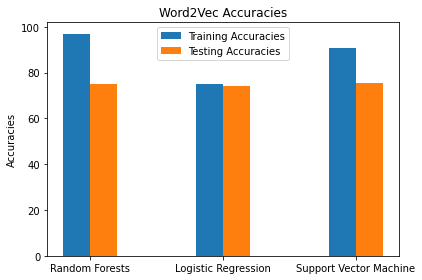

In [47]:
labels = ["Random Forests", "Logistic Regression", "Support Vector Machine"]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Word2Vec Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()

Plotting the average training and testing accuracies after 10 Fold Cross Validation for each all the classifiers used. We can see that Support Vector Machine has the best accuracy.